In [1]:
import numpy as np
import numba
from numba import jit
import matplotlib.pyplot as plt
import pandas as pd
import scipy.linalg as lg

import EKFS_Library as ekfs

In [2]:
RunTime = 500

# measurements from two sensors
S1 = np.array([[-1.5, 0.5]]).T # Position of sensor 1
S2 = np.array([[1, 1]]).T      # Position of sensor 2
sd = 0.5       # Standard deviation of measurements
dt = 0.01       # Sampling period
x0 = np.array([[0.1, 0.2, 1, 0, 0]]).T    # Initial state


# This is the process noise covariance for non-linear dynamics
qc = 0.01
qw = 10
Q = np.array([[qc*dt**3/3,  0,           qc*dt**2/2, 0,          0],
              [0,          qc*dt**3/3,   0,         qc*dt**2/2,  0],
              [qc*dt**2/2,  0,           qc*dt,     0,          0],
              [0,          qc*dt**2/2,   0,         qc*dt,      0],
              [0,          0,           0,         0,          dt*qw]])

R = sd**2*np.eye(2)


# Measurement model
h_fun = lambda x: np.array([np.arctan2(x[1]-S1[1], x[0]-S1[0]),
                            np.arctan2(x[1]-S2[1], x[0]-S2[0])])

dh_fun = lambda x: np.array([[-(x[1]-S1[1])/((x[0]-S1[0])**2+(x[1]-S1[1])**2), (x[0]-S1[0])/((x[0]-S1[0])**2+(x[1]-S1[1])**2)]+[[0]]*(x.shape[0]-2),
                             [-(x[1]-S2[1])/((x[0]-S2[0])**2+(x[1]-S2[1])**2), (x[0]-S2[0])/((x[0]-S2[0])**2+(x[1]-S2[1])**2)]+[[0]]*(x.shape[0]-2)]).reshape(2,-1)

# This is the function for non-linear dynamics  
f_fun = lambda x: ekfs.f_turn(x,dt)
df_fun = lambda x: ekfs.f_turn_dx(x,dt)

In [3]:
Randn = pd.read_excel('Randn.xlsx').values

In [4]:
x0 = np.array([[0.1, 0.2, 1, 0]]).T
a = 1 + dt*10*np.cumsum(Randn[None,0,:RunTime])#(np.random.randn(1,RunTime))

x = x0
t = 0
X = []
Theta = []
T = []
for i in range(RunTime):
    F = np.array([[0, 0,  1,    0],
                  [0, 0,  0,    1],
                  [0, 0,  0,   a[i]],
                  [0, 0, -a[i], 0]])
    x = lg.expm(F*dt) @ x
#     x = f_fun(x) + np.random.multivariate_normal(np.zeros([Q.shape[0],]),Q,1).T
    y1 = np.arctan2(x[1]-S1[1], x[0]-S1[0]) + sd * Randn[(0,RunTime+2*i)] #np.random.randn()
    y2 = np.arctan2(x[1]-S2[1], x[0]-S2[0]) + sd * Randn[(0,RunTime+2*i+1)] #np.random.randn()
    t  = t + dt
    X.append(x)
    T.append(t)
    Theta.append( [y1, y2] )
    
X = np.array(X).reshape(RunTime,-1).T
y = np.array(Theta).reshape(RunTime,-1).T
T = np.array(T)[None,:]

X = np.concatenate([X,a[None,:]],axis=0)    #=[X;a]

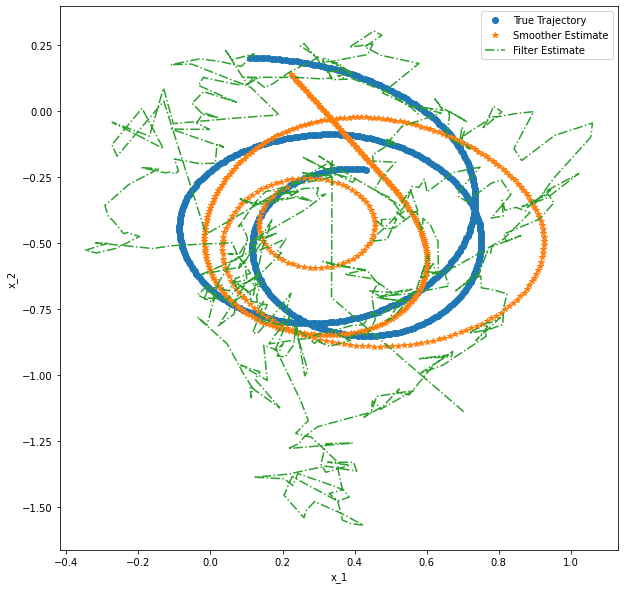

In [5]:
################################ Sequential EKFS #################################
m = np.array([[-1, -1, 0, 0, 0]]).T
# m = np.array([[0.1, 0.2, 1, 0, 0]]).T
P = np.diag([1, 1, 1, 1, 1])


MM = np.zeros((np.shape(m)[0], RunTime))
PP = np.zeros((np.shape(m)[0], np.shape(m)[0], RunTime))

ms = m.copy()
Ps = P.copy()
#EKFS

m = ms.copy()
P = Ps.copy()
for k in range(RunTime):

    if k > 0:
        f = f_fun(m)
        F = df_fun(m)

        m = f
        P = F @ P @ F.T + Q

    h = h_fun(m)
    H = dh_fun(m)

    S = H @ P @ H.T + R
    K = P @ H.T @ np.linalg.inv(S)
    m = m + K @ (y[:,k,None] - h)
    P = P - K @ S @ K.T

    MM[:,k,None] = m
    PP[:,:,k] = P

#EKS
ms = MM[:,-1,None]
Ps = PP[:,:,-1]
MMS = MM.copy()
PPS = PP.copy()
for k in range(RunTime-2 , -1, -1):
    m = MM[:,k,None]
    P = PP[:,:,k]

    f = f_fun(m)
    F = df_fun(m);

    mp = f
    Pp = F @ P @ F.T + Q
    Ck = P @ F.T @ np.linalg.inv(Pp)

    ms = m + Ck @ (ms - mp)
    Ps = P + Ck @ (Ps - Pp) @ Ck.T
    MMS[:,k,None] = ms
    PPS[:,:,k] = Ps


plt.figure(figsize=(10,10))
plt.plot(X[0,:],X[1,:],'o',
         MMS[0,:],MMS[1,:],'*',
         MM[0,:], MM[1,:],'-.')
c=plt.legend(['True Trajectory','Smoother Estimate', 'Filter Estimate'])
a=plt.xlabel('x_1')
b=plt.ylabel('x_2')

In [6]:
################################ Parallel Computation #################################
m0 = np.array([[-1, -1, 0, 0, 0]]).T
P0 = np.diag([1, 1, 1, 1, 1])
x0 = m0 + np.linalg.cholesky(P0) @ np.random.randn(5,1)


X_hat = np.zeros((5,RunTime))
for i in range(11):
    
    a = ekfs.filteringInitializer(Q, R, y, f_fun, df_fun, h_fun, dh_fun, X_hat, m0, P0, RunTime)

    ekfs_res = ekfs.parallelScanAlgorithm(a,RunTime, ekfs.filtering)

    ekfs_m_ps = []
    ekfs_P_ps = []
    for k in range(len(ekfs_res)): 
        ekfs_m_ps.append(ekfs_res[k]['b'])
        ekfs_P_ps.append(ekfs_res[k]['C'])

    X_hat = np.array(ekfs_m_ps).reshape(-1,len(ekfs_res[k]['b'])).T
    eks_m_ps = ekfs_m_ps.copy()
    eks_P_ps = ekfs_P_ps.copy()
for i in range(1):
    b = ekfs.smoothingInitializer(Q, f_fun, df_fun, X_hat, eks_m_ps, eks_P_ps, RunTime)

    rts_res = ekfs.parallelScanAlgorithm(b,RunTime, ekfs.smoothing)

    for k in range(RunTime):
        X_hat[:,RunTime-k-1,None] = rts_res[k]['g']
        eks_m_ps[RunTime-k-1] = rts_res[k]['g']
        eks_P_ps[RunTime-k-1] = rts_res[k]['L']
        
        
# y_hat = np.zeros((2,RunTime))
# for k in range(RunTime):

In [7]:
ekfs_m_ps = np.array(ekfs_m_ps).reshape(-1,5).T

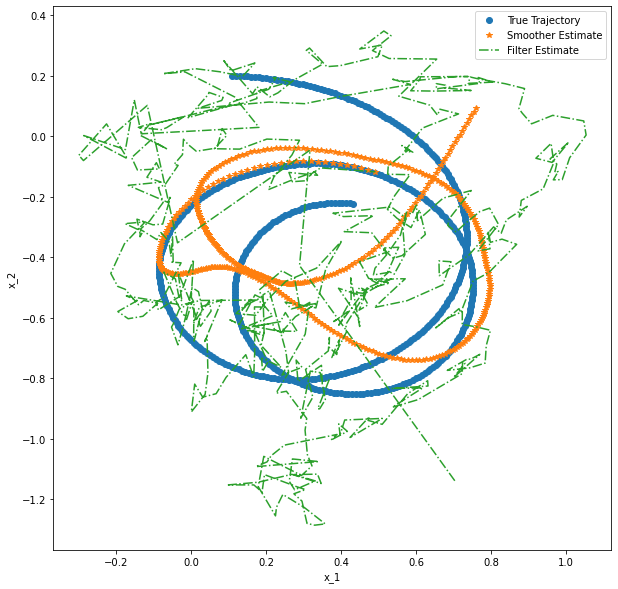

In [8]:
plt.figure(figsize=(10,10))
plt.plot(X[0,:],X[1,:],'o',
         X_hat[0,:],X_hat[1,:],'*',
         ekfs_m_ps[0,:], ekfs_m_ps[1,:],'-.')
c=plt.legend(['True Trajectory','Smoother Estimate', 'Filter Estimate'])
a=plt.xlabel('x_1')
b=plt.ylabel('x_2')